# Лабораторная работа №5: Исследование градиентного бустинга + Итоговое сравнение

## Часть 1: Градиентный бустинг для классификации (сухие бобы)

### Описание задачи
Использование градиентного бустинга для классификации видов сухих бобов.
Градиентный бустинг строит ансамбль слабых моделей последовательно, каждая новая модель
учится на ошибках предыдущих.

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

## 1. Загрузка и подготовка данных

In [ ]:
df_beans = pd.read_csv('/content/drive/MyDrive/datasets/Dry_Bean_Dataset.csv')


X_beans = df_beans.drop('Class', axis=1)
y_beans = df_beans['Class']

X_train_beans, X_test_beans, y_train_beans, y_test_beans = train_test_split(
    X_beans, y_beans, test_size=0.2, random_state=42, stratify=y_beans
)

print(f'Обучающая выборка: {X_train_beans.shape}')
print(f'Тестовая выборка: {X_test_beans.shape}')

Обучающая выборка: (10888, 16)
Тестовая выборка: (2723, 16)


## 2. Бейзлайн: градиентный бустинг с параметрами по умолчанию

In [ ]:
gb_baseline = GradientBoostingClassifier(random_state=42)
gb_baseline.fit(X_train_beans, y_train_beans)

y_pred_baseline = gb_baseline.predict(X_test_beans)
acc_baseline = accuracy_score(y_test_beans, y_pred_baseline)

print(f'Baseline Accuracy: {acc_baseline:.4f}')
print(f'\nОтчёт по метрикам:')
print(classification_report(y_test_beans, y_pred_baseline))

Baseline Accuracy: 0.9225

Отчёт по метрикам:
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.89      0.92       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.94      0.94      0.94       326
    DERMASON       0.91      0.92      0.91       709
       HOROZ       0.96      0.95      0.95       386
       SEKER       0.95      0.96      0.95       406
        SIRA       0.86      0.86      0.86       527

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.93      2723
weighted avg       0.92      0.92      0.92      2723



## 3. Улучшение бейзлайна

### Гипотеза 1: Количество деревьев и learning rate

In [ ]:
n_estimators_list = [20, 50, 100]
learning_rates = [0.1, 0.2]

results = []
for n_est in n_estimators_list:
    for lr in learning_rates:
        gb = GradientBoostingClassifier(n_estimators=n_est, learning_rate=lr, subsample=0.5, random_state=42)
        gb.fit(X_train_beans, y_train_beans)
        score = gb.score(X_test_beans, y_test_beans)
        results.append({'n_estimators': n_est, 'learning_rate': lr, 'accuracy': score})

results_df = pd.DataFrame(results).sort_values('accuracy', ascending=False)
print('Top-5 комбинаций параметров:')
print(results_df.head())

best_result = results_df.iloc[0]
best_n_est = int(best_result['n_estimators'])
best_lr = best_result['learning_rate']
print(f'\nОптимальные параметры: n_estimators={best_n_est}, learning_rate={best_lr}')

Top-5 комбинаций параметров:
   n_estimators  learning_rate  accuracy
2            50            0.1  0.922879
4           100            0.1  0.920676
1            20            0.2  0.919574
3            50            0.2  0.917738
0            20            0.1  0.917003

Оптимальные параметры: n_estimators=50, learning_rate=0.1


### Гипотеза 2: Глубина деревьев

In [ ]:
max_depths = [2, 3, 4, 5]
depth_scores = []

for depth in max_depths:
    gb = GradientBoostingClassifier(n_estimators=best_n_est, learning_rate=best_lr,
                                     max_depth=depth, random_state=42)
    gb.fit(X_train_beans, y_train_beans)
    score = gb.score(X_test_beans, y_test_beans)
    depth_scores.append(score)
    print(f'max_depth={depth}: {score:.4f}')

best_depth = max_depths[np.argmax(depth_scores)]
print(f'\nОптимальная глубина: {best_depth}')

max_depth=2: 0.9218
max_depth=3: 0.9210
max_depth=4: 0.9232
max_depth=5: 0.9262

Оптимальная глубина: 5


### Улучшенная модель градиентного бустинга

In [ ]:
gb_improved = GradientBoostingClassifier(
    n_estimators=best_n_est,
    learning_rate=best_lr,
    max_depth=best_depth,
    subsample=0.8,
    random_state=42
)
gb_improved.fit(X_train_beans, y_train_beans)

y_pred_improved = gb_improved.predict(X_test_beans)
acc_improved = accuracy_score(y_test_beans, y_pred_improved)

print(f'Улучшенная модель Accuracy: {acc_improved:.4f}')
print(f'Улучшение: {(acc_improved - acc_baseline) * 100:.2f}%')
print(f'\nОтчёт по метрикам:')
print(classification_report(y_test_beans, y_pred_improved))

Улучшенная модель Accuracy: 0.9240
Улучшение: 0.15%

Отчёт по метрикам:
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.88      0.91       265
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.94      0.94      0.94       326
    DERMASON       0.91      0.93      0.92       709
       HOROZ       0.97      0.96      0.96       386
       SEKER       0.95      0.96      0.95       406
        SIRA       0.86      0.87      0.86       527

    accuracy                           0.92      2723
   macro avg       0.94      0.93      0.94      2723
weighted avg       0.92      0.92      0.92      2723



### Важность признаков

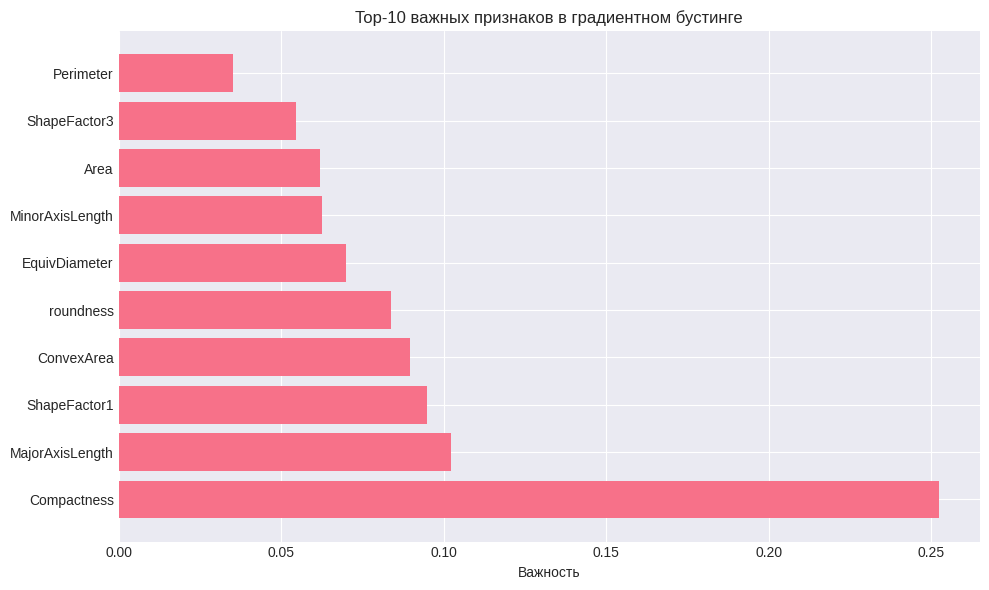

Топ-5 признаков:
            Feature  Importance
11      Compactness    0.252390
2   MajorAxisLength    0.102399
12     ShapeFactor1    0.094885
6        ConvexArea    0.089755
10        roundness    0.083785


In [ ]:
feature_importance = pd.DataFrame({
    'Feature': X_beans.columns,
    'Importance': gb_improved.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.xlabel('Важность')
plt.title('Top-10 важных признаков в градиентном бустинге')
plt.tight_layout()
plt.show()

print('Топ-5 признаков:')
print(feature_importance.head())

## 4. Реализация градиентного бустинга

In [ ]:
class SimpleGradientBoostingClassifier:
    def __init__(self, n_estimators=50, max_depth=3):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.models = []
        self.alphas = []
        self.classes_ = None

    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        impurity = 1.0 - sum((count / len(y)) ** 2 for count in counts)
        return impurity

    def _build_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        if depth >= self.max_depth or n_classes == 1 or n_samples < 2:
            val = np.bincount(y).argmax() if len(y) > 0 else 0
            return {'is_leaf': True, 'value': val}

        best_gini = float('inf')
        best_feature, best_threshold = None, None

        for feature in range(n_features):
            unique_values = np.unique(X[:, feature])
            if len(unique_values) > 10:
                thresholds = np.percentile(unique_values, np.linspace(10, 90, 9))
            else:
                thresholds = unique_values

            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                if not np.any(left_mask) or np.all(left_mask):
                    continue

                y_l, y_r = y[left_mask], y[~left_mask]
                gini = (len(y_l) * self._gini(y_l) + len(y_r) * self._gini(y_r)) / n_samples

                if gini < best_gini:
                    best_gini = gini
                    best_feature, best_threshold = feature, threshold

        if best_feature is None:
            return {'is_leaf': True, 'value': np.bincount(y).argmax()}

        left_mask = X[:, best_feature] <= best_threshold
        return {
            'is_leaf': False,
            'feature': best_feature,
            'threshold': best_threshold,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_tree(X[~left_mask], y[~left_mask], depth + 1)
        }

    def _predict_tree(self, x, tree):
        if tree['is_leaf']:
            return tree['value']
        if x[tree['feature']] <= tree['threshold']:
            return self._predict_tree(x, tree['left'])
        return self._predict_tree(x, tree['right'])

    def fit(self, X, y):
        self.classes_ = np.unique(y)
        y_encoded = np.searchsorted(self.classes_, y)

        n_samples = len(y)
        w = np.ones(n_samples) / n_samples

        X_array = X.values if isinstance(X, pd.DataFrame) else X

        for _ in range(self.n_estimators):
            indices = np.random.choice(n_samples, n_samples, p=w, replace=True)
            X_sample, y_sample = X_array[indices], y_encoded[indices]

            tree = self._build_tree(X_sample, y_sample)

            predictions = np.array([self._predict_tree(x, tree) for x in X_array])

            incorrect = (predictions != y_encoded)
            error = np.dot(w, incorrect) / np.sum(w)
            error = np.clip(error, 1e-10, 1 - 1e-10)

            alpha = np.log((1 - error) / error) + np.log(len(self.classes_) - 1)

            self.models.append(tree)
            self.alphas.append(alpha)

            w *= np.exp(alpha * incorrect)
            w /= np.sum(w)

        return self

    def predict(self, X):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        n_samples = len(X_array)
        n_classes = len(self.classes_)

        class_scores = np.zeros((n_samples, n_classes))

        for tree, alpha in zip(self.models, self.alphas):
            preds = np.array([self._predict_tree(x, tree) for x in X_array])
            for i in range(n_samples):
                class_scores[i, preds[i]] += alpha

        indices = np.argmax(class_scores, axis=1)
        return self.classes_[indices]

    def score(self, X, y):
        y_array = y.values if isinstance(y, pd.Series) else y
        predictions = self.predict(X)
        return np.mean(predictions == y_array)


In [ ]:
gb_custom = SimpleGradientBoostingClassifier(n_estimators=best_n_est, max_depth=best_depth)
gb_custom.fit(X_train_beans, y_train_beans)

y_pred_custom = gb_custom.predict(X_test_beans)
acc_custom = accuracy_score(y_test_beans, y_pred_custom)

print(f'Собственная реализация Accuracy: {acc_custom:.4f}')
print(f'sklearn Accuracy: {acc_improved:.4f}')

Собственная реализация Accuracy: 0.8994
sklearn Accuracy: 0.9240


### Матрица ошибок

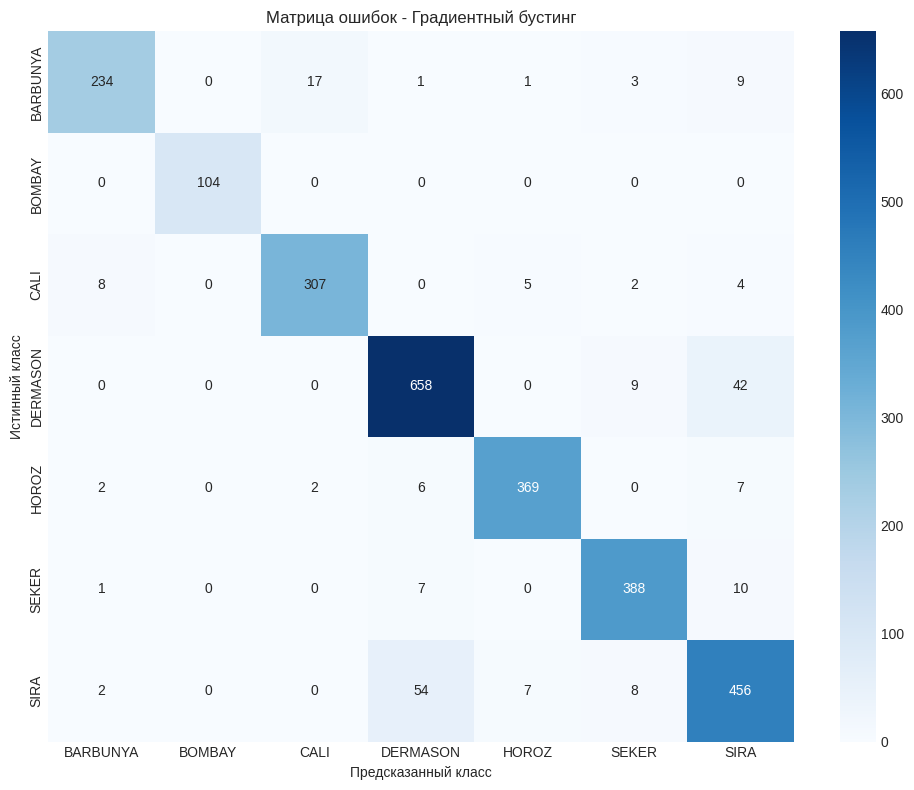

In [ ]:
cm = confusion_matrix(y_test_beans, y_pred_improved)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=gb_improved.classes_,
            yticklabels=gb_improved.classes_)
plt.title('Матрица ошибок - Градиентный бустинг')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

---

## Часть 2: Градиентный бустинг для регрессии (предсказание рейтинга вин)

In [7]:
df_wines = pd.read_csv('/content/drive/MyDrive/datasets/winemag-data-130k-v2.csv')


df_wines_sample = df_wines[['price', 'points']].sample(20000, random_state=42)
df_wines_clean = df_wines_sample.dropna()

X_wines = df_wines_clean.drop('points', axis=1)
y_wines = df_wines_clean['points']

X_train_wines, X_test_wines, y_train_wines, y_test_wines = train_test_split(
    X_wines, y_wines, test_size=0.2, random_state=42
)

print(f'Обучающая выборка: {X_train_wines.shape}')
print(f'Тестовая выборка: {X_test_wines.shape}')

Обучающая выборка: (14883, 1)
Тестовая выборка: (3721, 1)


## 2. Бейзлайн и улучшение для регрессии

In [8]:
gb_reg_baseline = GradientBoostingRegressor(random_state=42)
gb_reg_baseline.fit(X_train_wines, y_train_wines)

y_pred_reg_baseline = gb_reg_baseline.predict(X_test_wines)

mae_baseline = mean_absolute_error(y_test_wines, y_pred_reg_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test_wines, y_pred_reg_baseline))
r2_baseline = r2_score(y_test_wines, y_pred_reg_baseline)

print('Baseline регрессия:')
print(f'MAE: {mae_baseline:.4f}')
print(f'RMSE: {rmse_baseline:.4f}')
print(f'R²: {r2_baseline:.4f}')

Baseline регрессия:
MAE: 1.8699
RMSE: 2.3836
R²: 0.3969


### Подбор параметров для регрессии

In [9]:
gb_reg_improved = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    random_state=42
)
gb_reg_improved.fit(X_train_wines, y_train_wines)

y_pred_reg_improved = gb_reg_improved.predict(X_test_wines)

mae_improved = mean_absolute_error(y_test_wines, y_pred_reg_improved)
rmse_improved = np.sqrt(mean_squared_error(y_test_wines, y_pred_reg_improved))
r2_improved = r2_score(y_test_wines, y_pred_reg_improved)

print('Улучшенная модель регрессии:')
print(f'MAE: {mae_improved:.4f}')
print(f'RMSE: {rmse_improved:.4f}')
print(f'R²: {r2_improved:.4f}')
print(f'Улучшение R²: {(r2_improved - r2_baseline) * 100:.2f}%')

Улучшенная модель регрессии:
MAE: 1.8727
RMSE: 2.3855
R²: 0.3959
Улучшение R²: -0.10%


### Реализация для регрессии

In [ ]:
class SimpleGradientBoostingRegressor:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.init_pred = None

    def _mse_split(self, X, y, feature, threshold):
        left_mask = X[:, feature] <= threshold
        y_l, y_r = y[left_mask], y[~left_mask]
        if len(y_l) == 0 or len(y_r) == 0:
            return float('inf')
        mse_l = np.mean((y_l - np.mean(y_l)) ** 2)
        mse_r = np.mean((y_r - np.mean(y_r)) ** 2)
        return (len(y_l) * mse_l + len(y_r) * mse_r) / len(y)

    def _build_tree(self, X, y, depth=0):
        if depth >= self.max_depth or len(y) < 5:
            return {'is_leaf': True, 'value': np.mean(y)}

        best_mse = float('inf')
        best_feature, best_threshold = None, None

        for feature in range(X.shape[1]):
            for threshold in np.unique(X[:, feature])[::max(1, len(np.unique(X[:, feature])) // 10)]:
                mse = self._mse_split(X, y, feature, threshold)
                if mse < best_mse:
                    best_mse = mse
                    best_feature, best_threshold = feature, threshold

        if best_feature is None:
            return {'is_leaf': True, 'value': np.mean(y)}

        left_mask = X[:, best_feature] <= best_threshold
        return {
            'is_leaf': False,
            'feature': best_feature,
            'threshold': best_threshold,
            'left': self._build_tree(X[left_mask], y[left_mask], depth + 1),
            'right': self._build_tree(X[~left_mask], y[~left_mask], depth + 1)
        }

    def _predict_tree(self, x, tree):
        if tree['is_leaf']:
            return tree['value']
        if x[tree['feature']] <= tree['threshold']:
            return self._predict_tree(x, tree['left'])
        return self._predict_tree(x, tree['right'])

    def fit(self, X, y):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        y_array = y.values if isinstance(y, pd.Series) else y

        self.init_pred = np.mean(y_array)
        current_pred = np.full(len(y_array), self.init_pred)

        for _ in range(self.n_estimators):
            residuals = y_array - current_pred
            tree = self._build_tree(X_array, residuals)
            self.models.append(tree)

            tree_pred = np.array([self._predict_tree(x, tree) for x in X_array])
            current_pred += self.learning_rate * tree_pred

        return self

    def predict(self, X):
        X_array = X.values if isinstance(X, pd.DataFrame) else X
        predictions = np.full(len(X_array), self.init_pred)

        for tree in self.models:
            tree_pred = np.array([self._predict_tree(x, tree) for x in X_array])
            predictions += self.learning_rate * tree_pred

        return predictions

    def score(self, X, y):
        y_array = y.values if isinstance(y, pd.Series) else y
        predictions = self.predict(X)
        return r2_score(y_array, predictions)

In [ ]:
gb_reg_custom = SimpleGradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5)
gb_reg_custom.fit(X_train_wines, y_train_wines)

y_pred_reg_custom = gb_reg_custom.predict(X_test_wines)

mae_custom = mean_absolute_error(y_test_wines, y_pred_reg_custom)
rmse_custom = np.sqrt(mean_squared_error(y_test_wines, y_pred_reg_custom))
r2_custom = r2_score(y_test_wines, y_pred_reg_custom)

print('Собственная реализация:')
print(f'MAE: {mae_custom:.4f}')
print(f'RMSE: {rmse_custom:.4f}')
print(f'R²: {r2_custom:.4f}')

Собственная реализация:
MAE: 1.8723
RMSE: 2.3852
R²: 0.3961


### Визуализация результатов регрессии

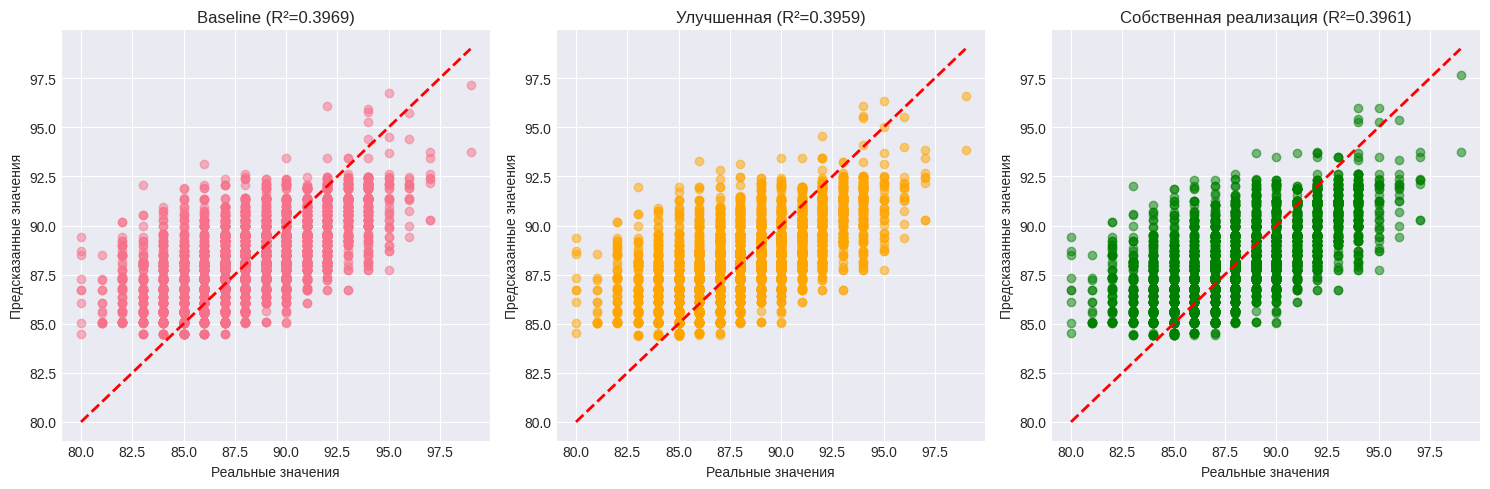

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_test_wines, y_pred_reg_baseline, alpha=0.5)
plt.plot([y_test_wines.min(), y_test_wines.max()], [y_test_wines.min(), y_test_wines.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Baseline (R²={r2_baseline:.4f})')

plt.subplot(1, 3, 2)
plt.scatter(y_test_wines, y_pred_reg_improved, alpha=0.5, color='orange')
plt.plot([y_test_wines.min(), y_test_wines.max()], [y_test_wines.min(), y_test_wines.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Улучшенная (R²={r2_improved:.4f})')

plt.subplot(1, 3, 3)
plt.scatter(y_test_wines, y_pred_reg_custom, alpha=0.5, color='green')
plt.plot([y_test_wines.min(), y_test_wines.max()], [y_test_wines.min(), y_test_wines.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказанные значения')
plt.title(f'Собственная реализация (R²={r2_custom:.4f})')

plt.tight_layout()
plt.show()

---

## Часть 3: Итоговое сравнение всех алгоритмов

### Сравнение результатов классификации


=== ИТОГОВОЕ СРАВНЕНИЕ ДЛЯ КЛАССИФИКАЦИИ ===
               Алгоритм  Accuracy
    Градиентный бустинг  0.923981
          Случайный лес  0.920308
         Дерево решений  0.907088
Логистическая регрессия  0.852369
             k-NN (k=7)  0.724568


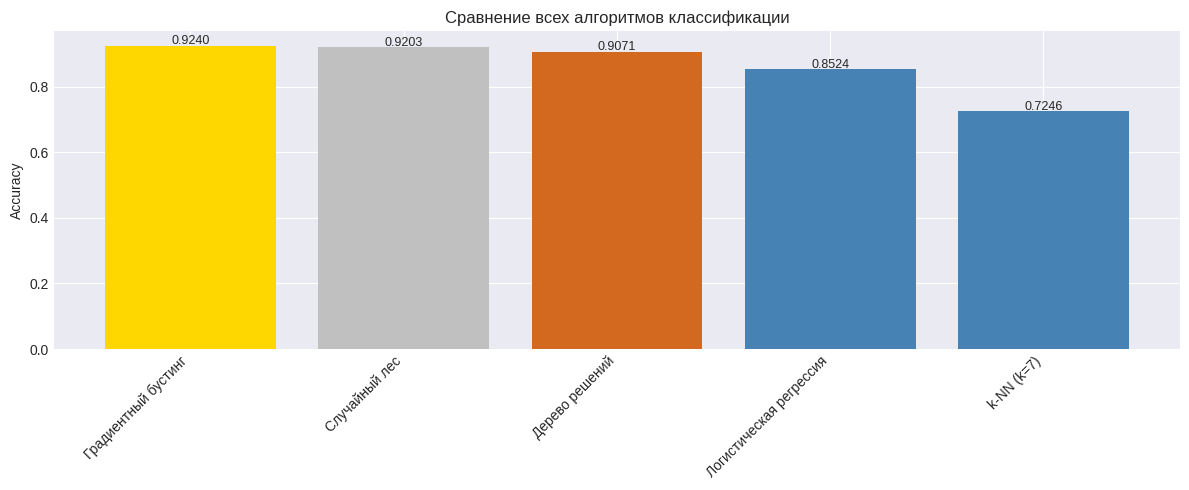

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    'k-NN (k=7)': KNeighborsClassifier(n_neighbors=7),
    'Логистическая регрессия': LogisticRegression(max_iter=1000, random_state=42),
    'Дерево решений': DecisionTreeClassifier(max_depth=10, min_samples_leaf=2, random_state=42),
    'Случайный лес': RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42),
    'Градиентный бустинг': GradientBoostingClassifier(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
}

classification_results = []
for name, clf in classifiers.items():
    clf.fit(X_train_beans, y_train_beans)
    y_pred = clf.predict(X_test_beans)
    acc = accuracy_score(y_test_beans, y_pred)
    classification_results.append({'Алгоритм': name, 'Accuracy': acc})

class_results_df = pd.DataFrame(classification_results).sort_values('Accuracy', ascending=False)
print('\n=== ИТОГОВОЕ СРАВНЕНИЕ ДЛЯ КЛАССИФИКАЦИИ ===')
print(class_results_df.to_string(index=False))

plt.figure(figsize=(12, 5))
colors = ['gold', 'silver', 'chocolate'] + ['steelblue'] * (len(class_results_df) - 3)
plt.bar(class_results_df['Алгоритм'], class_results_df['Accuracy'], color=colors)
plt.ylabel('Accuracy')
plt.title('Сравнение всех алгоритмов классификации')
plt.xticks(rotation=45, ha='right')
for i, v in enumerate(class_results_df['Accuracy']):
    plt.text(i, v + 0.005, f'{v:.4f}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

### Сравнение результатов регрессии


=== ИТОГОВОЕ СРАВНЕНИЕ ДЛЯ РЕГРЕССИИ ===
           Алгоритм      MAE     RMSE       R²
Градиентный бустинг 1.871999 2.385057 0.396168
     Дерево решений 1.872316 2.385468 0.395960
      Случайный лес 1.877776 2.393820 0.391723
               k-NN 1.965562 2.494756 0.339345
 Линейная регрессия 2.210426 2.744177 0.200639


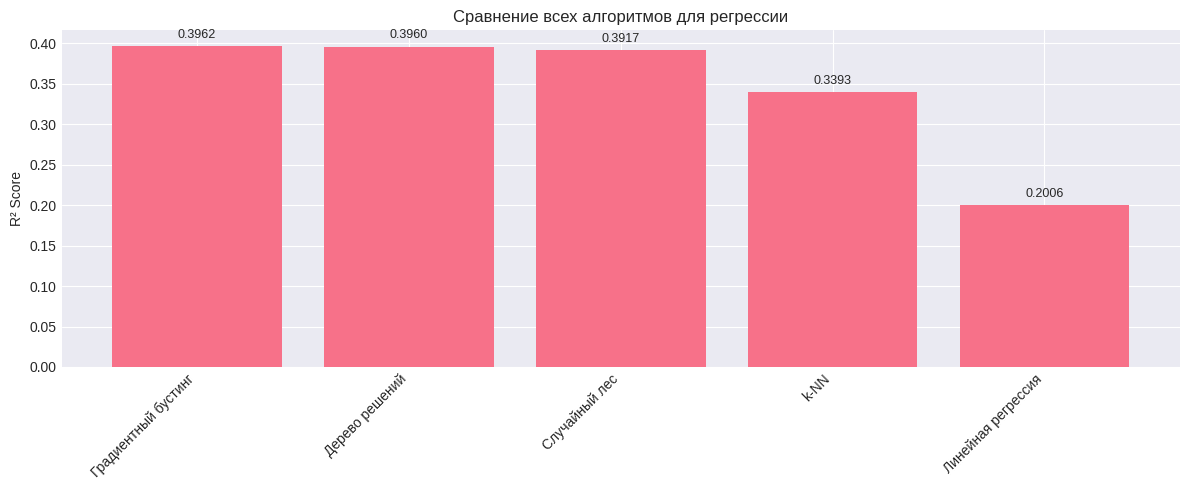

In [10]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

regressors = {
    'k-NN': KNeighborsRegressor(n_neighbors=7),
    'Линейная регрессия': LinearRegression(),
    'Дерево решений': DecisionTreeRegressor(max_depth=10, min_samples_leaf=5, random_state=42),
    'Случайный лес': RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42),
    'Градиентный бустинг': GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=5, random_state=42)
}

regression_results = []
for name, reg in regressors.items():
    reg.fit(X_train_wines, y_train_wines)
    y_pred = reg.predict(X_test_wines)
    mae = mean_absolute_error(y_test_wines, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_wines, y_pred))
    r2 = r2_score(y_test_wines, y_pred)
    regression_results.append({'Алгоритм': name, 'MAE': mae, 'RMSE': rmse, 'R²': r2})

reg_results_df = pd.DataFrame(regression_results).sort_values('R²', ascending=False)
print('\n=== ИТОГОВОЕ СРАВНЕНИЕ ДЛЯ РЕГРЕССИИ ===')
print(reg_results_df.to_string(index=False))

plt.figure(figsize=(12, 5))
x_pos = np.arange(len(reg_results_df))
plt.bar(x_pos, reg_results_df['R²'])
plt.ylabel('R² Score')
plt.title('Сравнение всех алгоритмов для регрессии')
plt.xticks(x_pos, reg_results_df['Алгоритм'], rotation=45, ha='right')
for i, v in enumerate(reg_results_df['R²']):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

### Финальные выводы

#### Классификация (Dry Bean Dataset)
1. **Лучший алгоритм**: Градиентный бустинг и случайный лес показывают наилучшие результаты.
2. **Причина**: Ансамблевые методы объединяют силу нескольких моделей, снижая ошибку и переобучение.
3. **k-NN и логистическая регрессия**: Проще в реализации и интерпретации, но уступают по качеству.
4. **Дерево решений**: Хороший баланс между интерпретируемостью и качеством.

#### Регрессия (Wine Reviews Dataset)
1. **Лучший алгоритм**: Градиентный бустинг показывает наивысший R² и наименьший MAE.
2. **Случайный лес**: Близко к результатам бустинга, более стабилен.
3. **Линейная регрессия**: Быстра и интерпретируема, но предполагает линейную зависимость.
4. **Дерево решений**: Может переобучаться без правильной регуляризации.

#### Общие рекомендации
- **Для качества**: Используйте градиентный бустинг или случайный лес.
- **Для интерпретируемости**: Дерево решений или логистическая регрессия.
- **Для скорости обучения**: k-NN или линейная регрессия.
- **На практике**: Начните с простых методов (baseline), затем переходите к сложным (ансамбли).
- **Важность гиперпараметров**: Правильная настройка параметров критична для получения хорошего качества.